# DSCI 550 Assignment 1
### Sunday 03/14/21

Team Banana 🍌

#### Group Members
- Olivia Fryt <fryt@usc.edu> 
- Katie Chak <chakw@usc.edu>
- Madeleine Thompson <mjt43250@usc.edu> 
- Sarah Pursley <spursley@usc.edu> 
- Amber Yu <qiuyunyu@usc.edu> 
- Claudia Winarko <cpwinark@usc.edu> 

## 1. Download/Install Apache Tika

##### Start GeoTopicParser-enabled Tika Server:

Run a GeoTopicParser-enabled Apache Tika Server in the background on localhost:9998. Containerized in my repo: https://github.com/frytoli/geotopic-parser-enabled-tika-docker
```
docker run -d -p 127.0.0.1:9998:9998 fryto/gtp-tika:latest
```

##### Python Options:

Install python Tika (this happens within this notebook):
```
pip install tika
```

## 2. Download/Install D3.js
- Package: http://d3js.org/
- Visual gallery wiki: https://github.com/mbostock/d3/wiki/Tutorials


## 3. Download Nigerian Price Fraud Email Dataset¶

Source: https://www.kaggle.com/rtatman/fraudulent-email-corpus

All resource files located in ```./data```

In [1]:
import os
import sys
import json

In [65]:
# Path to the location of the local directory where we're storing our data and resources
path_to_data = os.path.join(os.getcwd(), 'data')

# Path to raw fraudulent emails dataset from kaggle
infile = 'fraudulent_emails_copy.txt'
path_to_infile = os.path.join(path_to_data, infile)

# Path to our master processed and enriched fraudulent emails dataset
outfile = 'fraudulent_emails.json'
path_to_outfile = os.path.join(path_to_data, outfile)

# Path to our combined dataset from the fraudulent email corpus and our four additional datasets from question 6
featurefile = 'fraudulent_emails_features.json'
path_to_featurefile = os.path.join(path_to_data, featurefile)

# Path to Tika-Similarity
path_to_tikasimilarity = os.path.join(os.getcwd(), 'tika-similarity')

# Path to our final TSV
tsvfile = 'fraudulent_emails.tsv'
path_to_tsvfile = os.path.join(path_to_data, tsvfile)

In [3]:
# Prepare method to save a checkpoint of the data to the "outfile"
def save_to_outfile(data):
    with open(path_to_outfile, 'w') as outjson:
        json.dump(data, outjson, indent=2)
    print(f'Data saved to {path_to_outfile}')

### 4.1. "Convert" messages to json with Tika
**NOTE:**
Use of the Tika CLI yields different (and better) results than directly using the API to parse files. I can't figure out why this is. The Tika python CLI "parse" command uses the parseAndSave() method (https://github.com/chrismattmann/tika-python/blob/d692c0ffa6b85d099019de9b94888fb4c2a48040/tika/tika.py#L261) that in turn sends data to the parse1() method (https://github.com/chrismattmann/tika-python/blob/d692c0ffa6b85d099019de9b94888fb4c2a48040/tika/tika.py#L310) which interfaces with Tika to complete parsing. Interestingly enough, the from_file() parsing method in the Tika python library (https://github.com/chrismattmann/tika-python/blob/d692c0ffa6b85d099019de9b94888fb4c2a48040/tika/parser.py#L23) also passes data through the parse1() method to Tika. The only main difference between parseAndSave() and from_file() is the way the output data is handled and returned: the parseAndSave() method simply writes the item at index 1 in the returned json on a new line while the from_file() method sends the data returned from Tika to the _parse() method (https://github.com/chrismattmann/tika-python/blob/d692c0ffa6b85d099019de9b94888fb4c2a48040/tika/parser.py#L68) for additional parsing

In [4]:
!{sys.executable} -m pip install tika
import tika
from tika import tika

In [5]:
# load & parse json file using tika parser
parsed = json.loads(tika.parse1('all', path_to_infile)[1])

# Ignore the first returned item, as it is associated with the infile
messages = parsed[1:]

# Save a checkpoint
save_to_outfile(messages)

Data saved to /Users/olivia/Documents/viterbi/DSCI550/assignment1/other/dsci550-assignment1/final_submission/data/fraudulent_emails.json


### 4.2. Ensure each message is a separate json entity

*New key ```embedded_resources```*

In [6]:
# Find and attribute message attachments (these are parsed as separate json blobs)
#   * Attachment (embedded resource) metadata is stored in the json object(s) directly before the main message object in the list returned from Tika
resource_indicies = []
resources = []
count = 0
for message in messages:
    # If at least one resource needs to be added...
    if len(resources) > 0:
        # If there seems to be another resource attached to the same message, append it to resources, save item index, and continue
        if message['X-TIKA:embedded_depth'] != '1':
            resource_indicies.append(count)
            resources.append(message)
        # Else if the current message is the main message (aka it is not an embedded message)...
        elif message['X-TIKA:embedded_depth'] == '1':
            # Iterate over the resources...
            for resource in resources:
                # Assume the message (as long as it's immediately after the attachment(s)) is associated with the attachment(s)
                if 'embedded_resources' not in message:
                    message['embedded_resources'] = [resource]
                else:
                    message['embedded_resources'].append(resource)
            # Reset
            resources = []
        else:
            print('[!] Houston we have a problem')
            # Reset
            resources = []
    # Otherwise, check if the current message is an embedded resource
    elif message['X-TIKA:embedded_depth'] != '1':
        resource_indicies.append(count)
        resources = [message]
    # Increment the counter
    count += 1

# Remove messages that are embedded resources -- best practice is not to manipulate a list while iterating over it
delta = 0
for index in resource_indicies:
    del messages[index-delta]
    delta +=1

print(f'{len(resource_indicies)} embedded resources attributed to {len(messages)} total messages')

# Save a checkpoint
save_to_outfile(messages)

51 embedded resources attributed to 3978 total messages
Data saved to /Users/olivia/Documents/viterbi/DSCI550/assignment1/other/dsci550-assignment1/final_submission/data/fraudulent_emails.json


## 5. Dataset Enrichment with Attack Type and Attacker Stylometrics
---

### Pre-Analysis: Message Contents Language Identification
Before analysis, use Tika to identify the language of each message's body

*New key ```TIKA-language```*

#### **Import Standard Python Packages**

In [7]:
# os and sys already called
!{sys.executable} -m pip install requests numpy pandas 
import requests
import re
import numpy as np
import pandas as pd

In [8]:
# Method for communicating with Tika Server
def languagedetect_string(string):
    r = requests.put('http://localhost:9998/language/string', data=string)
    if r.status_code == 200:
        return r.text


whitespace_ptrn = re.compile(r'\s')
langs = dict()

# Iterate over messages
for message in messages:
    # Normalize all whitespace in message body
    norm_content = whitespace_ptrn.sub(' ', message['X-TIKA:content']).lower().encode('utf-8')
    # Evaluate language with Tika
    lang = languagedetect_string(norm_content)
    if lang in langs:
        langs[lang] += 1
    else:
        langs[lang] = 1
    # Save language
    message['TIKA-language'] = lang

# Output the languages and counts
for key, value in langs.items():
    print(f'{key} : {value}')

# Save a checkpoint
save_to_outfile(messages)

en : 3929
fr : 45
pt : 1
de : 1
es : 2
Data saved to /Users/olivia/Documents/viterbi/DSCI550/assignment1/other/dsci550-assignment1/final_submission/data/fraudulent_emails.json


### 5.a. Attack Type Classification
- Begin by generating a word cloud to gain insight into the content of the messages:

*New key ```se_tags```*

In [9]:
!{sys.executable} -m pip install wordcloud matplotlib 
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
#import re

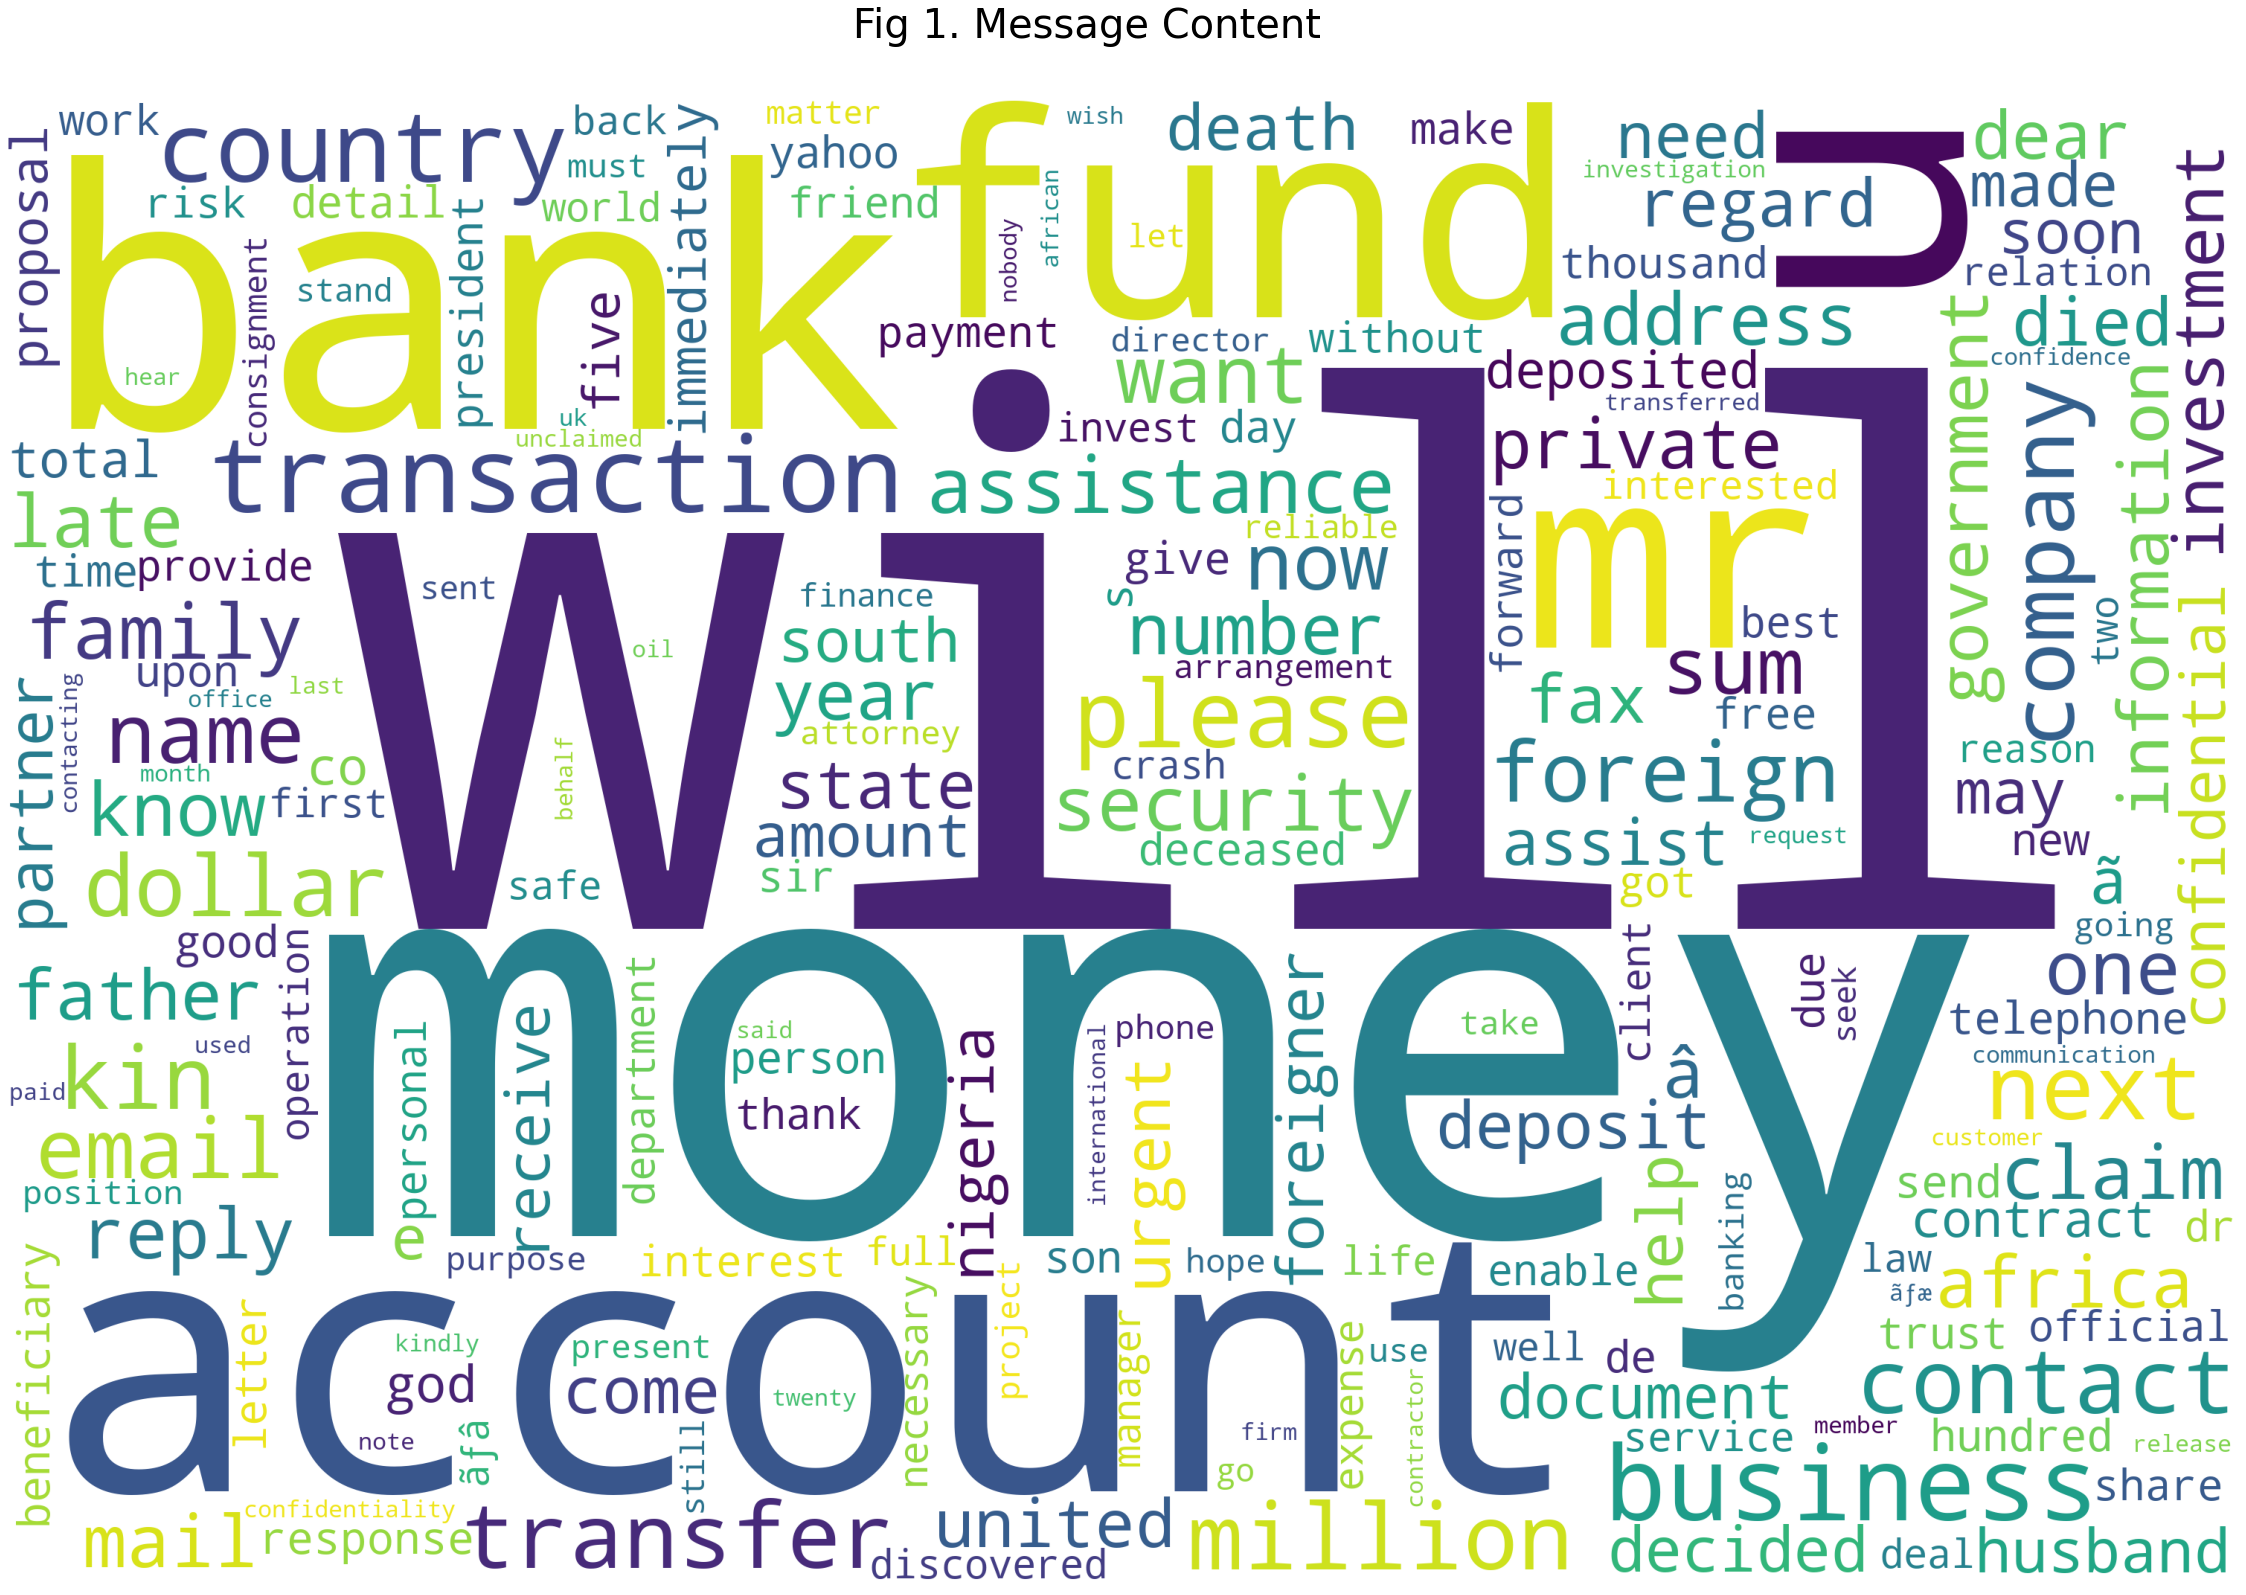

In [10]:
# Join and normalize all message contents and message subjects as strings
whitespace_ptrn = re.compile(r'\s')
cloud_corpus = ' '.join(whitespace_ptrn.sub(' ', message['X-TIKA:content']).lower().strip() for message in messages)

# Generate word cloud
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = set(STOPWORDS),
    random_state = 1,
    collocations = False
).generate(str(cloud_corpus))

# Plot
fig = plt.figure(1, figsize=(40, 30))
plt.axis('off')
fig.suptitle('Fig 1. Message Content', fontsize=40)
fig.subplots_adjust(top=1.06)

plt.imshow(wordcloud)
plt.show()

Categorize the messages into the following social engineering types by 
1.  Scanning a compiled set of keywords 
2.  Recognizing suspicious attachments/resources (in other words, messages with an attachment are considered to be of SE type "malware"):

**SE Types:** Reconnaissance, Social Engineering, Malware, Phishing

**NOTE:** We are not taking languages other than English into account.

**NOTE:** Intelligent categorization into these four categories is not possible without training data (must be supervised).

In [11]:
keywords = {
    'recon': ['reply back', 'click here', 'confidential', 'contact', 'response', 'private', 'personal', 'information', 'confidentiality', 'call me', 'get back to me', 'contact me immediately'],
    'social_engineering': ['your friend', 'comrade', 'urgent', 'need help', 'threat', 'act now', '$', 'money', 'transaction', 'give', 'assist', 'business', 'fund', 'help', 'unclaimed', 'please', 'died', 'solicit', 'urgently', 'dear friend', 'dollar', 'sum'],
    'malware': ['click here', 'http'],
    'phishing': ['social security', 'ssn', 'date of birth', 'birthday', 'dob', 'account number', 'bank', 'beneficiary', 'password', 'phone number', 'fax number', 'company address', 'phone', 'telephone', 'tel number', 'personal information', 'e-mail', 'email', 'fax', 'company name', 'full name']
}

# Keep count of keywords to get more insight/clean keywords
kw_count = {kw:0 for kw in keywords}

# Tag messages
for message in messages:
    message['se_tags'] = []
    # Find keywords in message body
    for kw_type in keywords:
        for kw in keywords[kw_type]:
            if kw in message['X-TIKA:content']:
                if kw_type not in message['se_tags']:
                    message['se_tags'].append(kw_type)
                    kw_count[kw_type] += 1
    # If the message contains at least one attachment, classify it as "malware"
    if 'embedded_resources' in message:
        if 'malware' not in message['se_tags']:
            message['se_tags'].append('malware')
            kw_count['malware'] += 1
        

print('Count of messages by tag:')
for kw in sorted(kw_count, key=kw_count.get, reverse=True):
    print(f'  {kw}: {kw_count[kw]}')

# Save a checkpoint
save_to_outfile(messages)

Count of messages by tag:
  social_engineering: 3866
  recon: 3370
  phishing: 3167
  malware: 1351
Data saved to /Users/olivia/Documents/viterbi/DSCI550/assignment1/other/dsci550-assignment1/final_submission/data/fraudulent_emails.json


## 5.b. Attacker Stylometric Enrichment

### i. Find attacker title

*New key ```author_titles```*

**NOTE:** We are not taking languages other than English into account.

**NOTE:** Named entity recognition with NLTK does not notice titles without personalization. Therefore, fuzzy string matching was utilized.

In [12]:
!{sys.executable} -m pip install fuzzywuzzy python-Levenshtein
from fuzzywuzzy import process
from fuzzywuzzy import fuzz

check other notebook

In [13]:
# Define a set of sender titles
titles = titles = ['mr', 'mrs', 'miss', 'ms', 'siir', 'madame', 'honourable', 'lady', 'senator', 'governor', 'hon', 'col', 'colonel',
                   'president', 'partner', 'senior', 'ceo', 'executive', 'officer', 'chief', 'maitre', 'dr', 'doctor', 'barr', 'excellence', 'excellency',
                   'barrister', 'esq', 'esquire', 'manager', 'executive', 'sister', 'brother', 'captain', 'capt', 'head', 'lead', 'professor',
                   'director', 'prince', 'princess', 'king', 'queen', 'chairman', 'judge', 'engr', 'engineer', 'minister', 'master', 'lord']
abrv_titles = {
    'dr': 'doctor',
    'barr': 'barrister',
    'esq': 'esquire',
    'capt': 'captain',
    'engr': 'engineer',
    'ceo': 'chief executive officer',
    'hon': 'honourable',
    'col': 'colonel'
} # Note that CEO is a bit strange, as the title can be set from three different titles

# Iterate over messages
for message in messages:
    # Create "author_titles" key-value pair
    message['author_titles'] = []
    temp_titles = set()
    # Fuzzy match author name, if applicable
    if 'Author' in message:
        # If applicable, pick last author in author string to fuzzy match on (this item seems to have been parsed more cleanly by Tika)
        if len(message['Author']) > 1:
            author = message['Author'][-1].lower()
        else:
            author = message['Author'][0].lower()
        # Split author string by space, period, comma, and dash, and normalize (lowercase)
        split_author = re.split('[ .,-]', author.lower())
        # Iterate over titles
        for title in titles:
            # Iterate over split parts of author
            for part in split_author:
                # Fuzzy match the parse parts of the author string with each title
                ratio = fuzz.ratio(title, part)
                if ratio > 86: # 86 seems to be the threshold at which "mrs" != "mr" and "prince" != "princess"
                    # Add title to set
                    temp_titles.add(title)
    # If not title was found in the author name or an author name does not exist, separate message content at last comma, split, and fuzzy match
    if 'Author' not in message or len(temp_titles) == 0:
        indexof_last_comma = message['X-TIKA:content'].rfind(',')
        endof_body = message['X-TIKA:content'][indexof_last_comma+1:]
        # Split string by space, period, comma, and dash, and normalize (lowercase)
        split_endof_body = re.split('[\s.,\-()]', endof_body.lower())
        # Iterate over titles
        for title in titles:
            # Iterate over split parts of body
            for part in split_endof_body:
                # Fuzzy match the parse parts of the author string with each title
                ratio = fuzz.ratio(title, part)
                if ratio > 86: # 86 seems to be the threshold at which "mrs" != "mr" and "prince" != "princess"
                    # Add title to set
                    temp_titles.add(title)
    # Make titles consistent (handle abbreviations)
    # First a foremost, lets see if author is a ceo ** Note the comment above
    ceo_check = all(item in list(temp_titles) for item in ['chief', 'executive', 'officer'])
    if ceo_check:
        temp_titles.add('ceo')
        temp_titles.remove('chief')
        temp_titles.remove('executive')
        temp_titles.remove('officer')
    # Iterate over titles and add to message blob
    for title in temp_titles:
        try:
            message['author_titles'].append(abrv_titles[title])
        except:
            message['author_titles'].append(title)

# Save a checkpoint
save_to_outfile(messages)

Data saved to /Users/olivia/Documents/viterbi/DSCI550/assignment1/other/dsci550-assignment1/final_submission/data/fraudulent_emails.json


### ii.  Attribute a level of urgency ("urgency score") to each message

*New key ```urgency_score```*

In [14]:
# Synonyms/antonyms of "urgent" from thesaurus.com: https://www.thesaurus.com/browse/urgent
#  Some words removed to avoid confusion, mainly in regards to sender titles i.e. "chief" and "principal"
#  Some words added after manual review of messages

urgency_ratings = {
    2: ['urgency', 'urgent', 'compelling', 'compel', 'critical', 'crucial', 'demanding', 'essential', 'immediate',
        'imperative', 'important', 'indispensable', 'necessary', 'persuasive', 'pressing', 'serious', 'vital', 'weighty',
        'as soon as possible', 'may not exceed', 'now'],
    1: ['burning', 'called-for', 'clamant', 'clamorous', 'crying', 'demanded', 'driving', 'exigent', 'foremost', 'heavy',
        'hurry-up', 'impelling', 'importunate', 'insistent', 'instant', 'leading', 'life and death', 'momentous', 'paramount',
        'primary', 'required', 'salient', 'top-priority', 'touch and go', 'touchy', 'wanted', 'quick', 'earliest response',
        'at once', 'right now'],
    -1: ['easy', 'facile', 'inessential', 'insignificant', 'light', 'minor', 'needless', 'nonessential', 'optional',
         'secondary', 'small', 'trivial', 'uncritical', 'unimportant', 'unnecessary', 'unsubstantial', 'voluntary',
         'eventually', 'later']
}

scores = []

# Iterate over messages
for message in messages:
    # Iterate over words in urgency ratings, see if they exist in the message's body, and compile a score accordingly
    message['urgency_score'] = 0
    for score in urgency_ratings:
        for word in urgency_ratings[score]:
            # If the word is found in the message's body content, add the associated score (note that antonyms take away from the overall urgency score)
            if word in message['X-TIKA:content'].lower():
                message['urgency_score'] += score
    scores.append(message['urgency_score'])

# Output max, avg, min of scores
print(f'Max "urgency score": {max(scores)}')
print(f'Avg "urgency score": {sum(scores)/len(scores)}')
print(f'Min "urgency score": {min(scores)}')

# Save a checkpoint
save_to_outfile(messages)

Max "urgency score": 15
Avg "urgency score": 4.414278531925591
Min "urgency score": -2
Data saved to /Users/olivia/Documents/viterbi/DSCI550/assignment1/other/dsci550-assignment1/final_submission/data/fraudulent_emails.json


### iii. Find the date/time of the email attack

** This was moved to AFTER geolocation discovery for accurate timezones **

Convert message creation timestamps to timezone-aware (if possible) ISO 8601 format strings

### iv. Categorize attacker's offering

*New keys: ```attacker_offering```*

<font color = darkblue>**Start by using k-means clustering to find natural clusters based on language to gain insight into the individual meanings behind the messages:**</font>

In [15]:
!{sys.executable} -m pip install sklearn tabulate

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from tabulate import tabulate
#import numpy as np
#import pandas as pd
#import re

In [16]:
def see_clusters(corpus, k=2):
    # Using TfidfVectorizer and English stopwords (because majority of messages are in English)
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(corpus)
    
    # Create model
    model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
    model.fit(X)
    
    # Get centroids and features
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    
    # Iterate and prepare data for table
    table_data = {}
    for i in range(k):
        key = f'Cluster {i}'
        table_data[key] = []
        for ind in order_centroids[i, :10]:
            table_data[key].append(terms[ind])
    
    # Output table
    print(tabulate(table_data, headers='keys'))

In [17]:
# First, join and normalize all message contents
whitespace_ptrn = re.compile(r'\s')
corpus = [whitespace_ptrn.sub(' ', message['X-TIKA:content']).lower().strip() for message in messages]

# Get insight from k-means clusters (mess with the value of k)
see_clusters(corpus, k=4)

Cluster 0    Cluster 1    Cluster 2    Cluster 3
-----------  -----------  -----------  -----------
contract     father       bank         husband
account      money        kin          money
transaction  country      account      funds
foreign      security     money        mrs
nigeria      assistance   mr           company
ministry     company      foreigner    bank
transfer     mother       deceased     fund
payment      family       transaction  contact
contracts    investment   claim        security
business     late         foreign      mr


- Topic 1: asks for money for family emergency {t1:["relative","deceased","money",]}
- Topic 2: asks for money for charity {t2:["charity","friend","bless"]}
- Topic 3: asks to transfer money to Africa for foreign assistance {t3:["Africa","funds","contract","foreign"]}
- Topic 4: asks for money for business investment funds {t4:["business","investment","transaction","document"]}
- Topic 5: job offer from Tasaki-Shinju {t5:["tasaki","shinju","company","family","job"]}
- Topic 6: offering sum of money from bank in Nigeria {t6:["foreign","fund","nigeria","country"]}
- Topic 7: need help to get sums of money (will split sum) {t7:["split", "unclaimed","transfer","claim","father"]}

In [18]:
!{sys.executable} -m pip install nltk spacy

import nltk
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

import spacy
from spacy.lang.en import English
!{sys.executable} -m spacy download en_core_web_sm

     |████████████████████████████████| 13.7 MB 8.4 MB/s eta 0:00:01


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [19]:
offerings={"t1":["relative","deceased","money","family"],
           "t2":["charity","friend","bless","cheque","organization","ramitez"],
           "t3":["Africa","funds","contract","foreign"],
           "t4":["business","investment","transaction","document"],
           "t5":["tasaki","shinju","company","family","job"],
           "t6":["foreign","fund","nigeria","country"],
           "t7":["split", "unclaimed","transfer","claim","father"]}

def get_ans(topic_wrd_cnt,total_word,topic_name):
    ratio=topic_wrd_cnt/total_word
    return (ratio,topic_name)    # returns tuple of topic name and its strength

In [20]:
# tokenize each word
spacy.load("en_core_web_sm")
spacy_parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = spacy_parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [21]:
# lemmatize each word
nltk.download('wordnet')
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

[nltk_data] Downloading package wordnet to /Users/olivia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
# filter stop words
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/olivia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [24]:
for message in messages:
    # initializing topic ratios
    t1=0
    t2=0
    t3=0
    t4=0
    t5=0
    t6=0
    t7=0
    words=0
    for k,v in offerings.items():
        #print(k,v)
        email=message["X-TIKA:content"].lstrip().strip()
        token=prepare_text_for_lda(email)
        #print(token)
        for word in token:
            if word in v and k=="t1":
                t1+=1
            if word in v and k=="t2":
                t2+=1
            if word in v and k=="t3":
                t3+=1
            if word in v and k=="t4":
                t4+=1
            if word in v and k=="t5":
                t5+=1
            if word in v and k=="t6":
                t6+=1
            if word in v and k=="t7":
                t7+=1
            words+=1
    t1=get_ans(t1,words,"t1")
    t2=get_ans(t2,words,"t2")
    t3=get_ans(t3,words,"t3")
    t4=get_ans(t4,words,"t4")
    t5=get_ans(t5,words,"t5")
    t6=get_ans(t6,words,"t6")
    t7=get_ans(t7,words,"t7")
    total_list=[t1,t2,t3,t4,t5,t6,t7]
    #print(total_list)
    #print(total_list)
    #sort list in ascending order
    total_list.sort()
    
    message["attacker_offering"]=total_list[-1]
    #print(message["offering"])

# Save a checkpoint
save_to_outfile(messages)  

Data saved to /Users/olivia/Documents/viterbi/DSCI550/assignment1/other/dsci550-assignment1/final_submission/data/fraudulent_emails.json


### v. Identify attacker's location
#### **Get geolocation with geoNames.txt**  
- Use GeoTopicParser in Tika: https://cwiki.apache.org/confluence/display/tika/GeoTopicParser   

*New keys: ```TIKA-GeoLocationParser```, ```IPInfo-data```*

**NOTES:**
Was unable to get GeoTopicParser to work with Python Tika, so I put together and am using a containerized GeoTopicParser-enabled Tika Server (my repo: https://github.com/frytoli/geotopic-parser-enabled-tika-docker). 
1. Run this in the background (see step 1 above), then run code below:
2. Find geolocations mentioned in each message's content with Tika's GeoLocationParser:

In [25]:
# import requests

In [26]:
# Define method for communicating with GeoTopicParser-enabled Tika Server
def geotopicparse_file(filename, filedata):
    headers = {
        'Content-Disposition': f'attachment; filename={filename}'
    }
    r = requests.put('http://localhost:9998/rmeta', headers=headers, data=filedata)
    if r.status_code == 200:
        return r.json()

    
whitespace_ptrn = re.compile(r'\s')

# Iterate over messages
for message in messages:
    # Normalize all whitespace in message body
    norm_content = whitespace_ptrn.sub(' ', message['X-TIKA:content']).encode('utf-8')
    # Parse each message content for geotopics
    parsed = geotopicparse_file('message.geot', norm_content)
    # Save extracted geolocations to message json
    message['TIKA-GeoLocationParser'] = parsed[0]

# Save a checkpoint
save_to_outfile(messages)

Data saved to /Users/olivia/Documents/viterbi/DSCI550/assignment1/other/dsci550-assignment1/final_submission/data/fraudulent_emails.json


<font color = DarkBlue>**Find geolocation based off of sender IP addresses using IPInfo (https://github.com/ipinfo/python) (note that IP addresses change, so this data might not be entirely accurate):**</font>

In [27]:
!{sys.executable} -m pip install ipinfo

import ipinfo
#import re

In [28]:
# Initialize ipinfo object and handler
ipinfo_token = 'eb65e70ef00bb6' # 50,000 free requests per month
handler = ipinfo.getHandler(ipinfo_token)

# Compile regex patterns
whitespace_ptrn = re.compile(r'\s')
ip_ptrn = re.compile(r'(?<![0-9])[1-9][0-9]{0,2}\.[1-9][0-9]{0,2}\.[1-9][0-9]{0,2}\.[1-9][0-9]{0,2}(?![0-9])')

# IP Parsing method
def parse_ip(string):
    # Normalize value to parse
    wstring = whitespace_ptrn.sub(' ', string)
    # Parse date from value
    ip = ip_ptrn.search(wstring)
    return ip

# Iterate over messages
for message in messages:
    ip = None
    if 'MboxParser-x-sender-ip' in message:
        # Preprocess string and parse ip address
        ip = parse_ip(message['MboxParser-x-sender-ip'])
    if 'MboxParser-x-senderip' in message:
        # Preprocess string and parse ip address
        ip = parse_ip(message['MboxParser-x-senderip'])
    if not ip and 'MboxParser-x-origination-ip' in message:
        # Preprocess string and parse ip address
        ip = parse_ip(message['MboxParser-x-origination-ip'])
    if not ip and 'Message:Raw-Header:X-ORIGINATE-IP' in message:
        # Preprocess string and parse ip address
        ip = parse_ip(message['Message:Raw-Header:X-ORIGINATE-IP'])
    if not ip and 'MboxParser-xoriginalsenderip' in message:
        # Preprocess string and parse ip address
        ip = parse_ip(message['MboxParser-xoriginalsenderip'])
    if not ip and 'MboxParser-x-original-ip' in message:
        # Preprocess string and parse ip address
        ip = parse_ip(message['MboxParser-x-original-ip'])
    if not ip and 'MboxParser-x-aol-ip' in message:
        # Preprocess string and parse ip address
        ip = parse_ip(message['MboxParser-x-aol-ip'])
    if not ip and 'MboxParser-x-php-remote_addr' in message:
        # Preprocess string and parse ip address
        ip = parse_ip(message['MboxParser-x-php-remote_addr'])
    if not ip and 'Message:Raw-Header:Message-ID' in message:
        # Preprocess string and parse ip address
        ip = parse_ip(message['Message:Raw-Header:Message-ID'])
    if not ip and 'MboxParser-xparam2' in message:
        # Preprocess string and parse ip address
        ip = parse_ip(message['MboxParser-xparam2'])
    
    if ip:
        # Get ip address details from ipinfo
        details = handler.getDetails(ip.group(0).strip())
        # Retrieve and save all detail information
        message['IPInfo-data'] = details.all

# Save a checkpoint
save_to_outfile(messages)

Data saved to /Users/olivia/Documents/viterbi/DSCI550/assignment1/other/dsci550-assignment1/final_submission/data/fraudulent_emails.json


### iii. Find the date/time of the email attack

Convert message creation timestamps to timezone-aware (if possible) ISO 8601 format strings

In [29]:
!{sys.executable} -m pip install pytz

import dateutil
from dateutil import parser
from pytz import timezone

In [30]:
# Compile regex patterns
whitespace_ptrn = re.compile(r'\s')
mboxfrom_date_ptrn = re.compile(r'(Mon|Tue|Wed|Thu|Fri|Sat|Sun) {1,2}(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)( [1-9][0-9]|  [1-9]) [0-9]{2}:[0-9]{2}:[0-9]{2} [1-2][0-9]{3}')
date_ptrn = re.compile(r'(Mon|Tue|Wed|Thu|Fri|Sat|Sun), [1-9][0-9]{0,1} (Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec) [1-2][0-9]{3} [0-9]{2}:[0-9]{2}:[0-9]{2} -[0-9]{4} \([A-Z]{3}\)')

nodate = []

# Iterate over messages
for message in messages:
    # Keep track of datetime object itself
    dt = None
    # If "Creation-Date" in message record, convert value directly to isoformat
    if 'Creation-Date' in message:
        # Convert "Creation-Date" to ISO 8601
        dt = parser.isoparse(message['Creation-Date'])
    # Otherwise, if "MboxParser-from" in message record, convert this value to isoformat AND use previously discovered geolocation for timezone
    elif 'MboxParser-from' in message:
        # Prioritize IP address timezone, then Tika GeoTopicParser locations
        if 'IPInfo-data' in message:
            # Normalize value to parse
            mboxparser_from = whitespace_ptrn.sub(' ', message['MboxParser-from'])
            # Parse date from value
            dtstr = mboxfrom_date_ptrn.search(mboxparser_from)
            if dtstr:
                dt = parser.parse(dtstr.group(0))
                # Update with timezone aware value
                tz = timezone(message['IPInfo-data']['timezone'])
                dt = tz.localize(dt)
        # Else parse date from 'MboxParser-return-path' or from 'MboxParser-x-sieve'/'MboxParser-from' if possible
        elif 'MboxParser-return-path' or 'MboxParser-x-sieve' in message:
            # 'MboxParser-return-path' logic
            if 'MboxParser-return-path' in message:
                # Handle potential types of 'MboxParser-return-path' value
                if type(message['MboxParser-return-path']) == str:
                    # Look for date pattern in string
                    dtstr = date_ptrn.search(message['MboxParser-return-path'])
                    # If a match was found, parse it to datetime
                    if dtstr:
                        # Parse out date
                        dt = parser.parse(dtstr.group(0))
                        # Acknowledge that timestamp was found
                        timestamp_found = True
                elif type(message['MboxParser-return-path']) == list:
                    # Iterate over items
                    for path in message['MboxParser-return-path']:
                        # Look for date pattern in string
                        dtstr = date_ptrn.search(path)
                        # If a match was found, parse it to datetime
                        if dtstr:
                            # Parse out date
                            dt = parser.parse(dtstr.group(0))
                            # Break out of loop
                            break
                else:
                    print('[!] Houston we have a problem')
            # 'MboxParser-x-sieve'/'MboxParser-from' logic
            if not dt and 'MboxParser-x-sieve' in message:
                # Look for date pattern in string
                dtstr = date_ptrn.search(message['MboxParser-x-sieve'])
                #
                # It seems that the value of 'MboxParser-from' is typically just a couple minutes different than the value from
                # 'MboxParser-x-sieve'. We'll check that this is the case, and if it is we'll use the timezone from 'MboxParser-x-sieve'
                # and the datetime value from 'MboxParser-from'
                #
                # If a match was found...
                if dtstr:
                    # Extract timezone from dtstr
                    tzstr = dtstr.group(0).split(' ')[-2]
                    # Normalize 'MboxParser-from' value to parse
                    mboxparser_from = whitespace_ptrn.sub(' ', message['MboxParser-from'])
                    # Parse date from value
                    dtstr = mboxfrom_date_ptrn.search(mboxparser_from)
                    # Combine datetime and timezone strings, and parse to datetime object
                    dt = parser.parse(f'{dtstr.group(0)} {tzstr}')
    
    # If no timestamp found yet, attempt to parse timezone unaware timestamp
    if not dt:
        # Normalize value to parse
        mboxparser_from = whitespace_ptrn.sub(' ', message['MboxParser-from'])
        # Parse date from value
        dtstr = mboxfrom_date_ptrn.search(mboxparser_from)
        if dtstr:
            dt = parser.parse(dtstr.group(0))

    # Store timestamp in message as ISO 8601 string
    message['timestamp'] = dt.isoformat()

# Save a checkpoint
save_to_outfile(messages)

Data saved to /Users/olivia/Documents/viterbi/DSCI550/assignment1/other/dsci550-assignment1/final_submission/data/fraudulent_emails.json


### vi. Attacker's alleged relationship to the recipient

*New key: ```relationship```*

In [31]:
relationship={"foreign_partner":["foreign","partner","father","majesty","assistance","sister"],
              "stranger_in_need":["wife","husband","son","father","sister"],
              "friend":["friend","dear","help","assistance","money"]}


for message in messages:
    # initializing topic ratios
    t1=0
    t2=0
    t3=0

    words=0
    for k,v in relationship.items():
        #print(k,v)
        email=message["X-TIKA:content"].lstrip().strip()
        token=prepare_text_for_lda(email)
        #print(token)
        for word in token:
            if word in v and k=="foreign_partner":
                t1+=1
            if word in v and k=="stranger_in_need":
                t2+=1
            if word in v and k=="friend":
                t3+=1
        
            words+=1
    t1=t1/words
    t2=t2/words
    t3=t3/words

    total_list=[t1,t2,t3]
    #print(total_list)
    #print(total_list)
    total_list.sort()    # Sort list in ascending order
    if total_list[-1]==t1:
        message["relationship"]="foreign_partner"
    elif total_list[-1]==t2:
        message["relationship"]="stranger_in_need"
    else:
        message["relationship"]="friend"
    #print(message["relationship"])

# Save a checkpoint
save_to_outfile(messages)

Data saved to /Users/olivia/Documents/viterbi/DSCI550/assignment1/other/dsci550-assignment1/final_submission/data/fraudulent_emails.json


### vii. Attacker email sentiment

*New key: ```Sentiment-Analysis```*

In [32]:
!{sys.executable} -m pip install nltk

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/olivia/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [33]:
#using pre-trained NLTK sentiment analyzer 
sia = SentimentIntensityAnalyzer()
for message in messages: 
    message['Sentiment_Analysis'] = sia.polarity_scores(message['X-TIKA:content'])
    
# Save a checkpoint
save_to_outfile(messages)

Data saved to /Users/olivia/Documents/viterbi/DSCI550/assignment1/other/dsci550-assignment1/final_submission/data/fraudulent_emails.json


### viii. Attacker language style

**1. Ratio of Misspelled Words**

Using spell-check algorithm from https://github.com/mammothb/symspellpy

*New key: ```misspelled_ratio```*

In [34]:
!{sys.executable} -m pip install symspellpy

import pkg_resources
from symspellpy import SymSpell, Verbosity
#import pandas as pd

In [35]:
# Initialize symspell object
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

# !!! Account for other languages? I.e. French and Spanish messages
# Find and load the dictonary resources
dictionary_path = pkg_resources.resource_filename('symspellpy', 'frequency_dictionary_en_82_765.txt')
bigram_path = pkg_resources.resource_filename('symspellpy', 'frequency_bigramdictionary_en_243_342.txt')
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
sym_spell.load_bigram_dictionary(bigram_path, term_index=0, count_index=2)

# Compile regex patterns to ignore in message body contents
whitespace_ptrn = re.compile(r'\s')
punctuation_ptrn = re.compile(r'[^\w\s\-]')
number_ptrn = re.compile(r'[0-9]')
letter_ptrn = re.compile(r'[a-z]')

# List of stopwords
stopwords = set(['mr', 'dr', 'mrs', 'usd', 'usdm', 'phd', 'hrm', 'ceo', 'drc', 'jk', 'mb', 'kg', 'nnpc', 'es', 'ie', 'ps', 'kabila'])

# Iterate over messages and find incorrect spellings
for message in messages:
    # Add author name to stopwords
    if 'Author' in message:
        if type(message['Author']) == list:
            author = message['Author'][-1]
        elif type(message['Author']) == str:
            author = message['Author']
        author = whitespace_ptrn.sub(' ', author)
        author = punctuation_ptrn.sub('', author).replace('_','')
        for part in author.split(' '):
            if part != '':
                stopwords.add(part.lower())
    # Count all words
    words = 0
    # Count misspellings
    misspellings = 0
    # Normalize and split message content
    content = whitespace_ptrn.sub(' ', message['X-TIKA:content'])
    content = punctuation_ptrn.sub('', content).replace('_','')
    content = number_ptrn.sub('', content)
    content = content.lower().split(' ')
    # Iterate over split content
    for word in content:
        # Ignore empty strings and words that do not have any letters (i.e. "--")
        if word and letter_ptrn.search(word):
            # Record word
            words += 1
            # Don't check spellings of stopwords or words with length <= 1
            if word not in stopwords and len(word)>1:
                suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
                # Record misspelled words
                if len(suggestions) > 1:
                    misspellings +=1
    # Save ratio of misspellings
    message['misspelled_ratio'] = misspellings/words

# Save a checkpoint
save_to_outfile(messages)

Data saved to /Users/olivia/Documents/viterbi/DSCI550/assignment1/other/dsci550-assignment1/final_submission/data/fraudulent_emails.json


<font color=darkblue>**Misspellings Distribution**</font>

In [36]:
misspells=[]
for message in messages:
    misspells.append(message["misspelled_ratio"])
    
mp_df=pd.DataFrame(misspells)
mp_df.describe()

,0
count,3978.000000
mean,0.021802
std,0.047104
min,0.000000
25%,0.008201
50%,0.014381
75%,0.023034
max,0.522152


In [37]:
msg_len=[]
for message in messages:
    msg_len.append(len(message["X-TIKA:content"].strip().lstrip().split(" ")))

In [38]:
mnorm_df=pd.concat([mp_df,pd.DataFrame(msg_len)],axis=1)
mnorm_df.columns=["misspell_ratio","msg_size"]
mnorm_df["norm_ratio"]=mnorm_df["misspell_ratio"]/mnorm_df["msg_size"]

mnorm_df.describe()

,misspell_ratio,msg_size,norm_ratio
count,3978.000000,3978.000000,3978.000000
mean,0.021802,433.031674,0.000081
std,0.047104,409.480770,0.000481
min,0.000000,2.000000,0.000000
25%,0.008201,312.000000,0.000018
50%,0.014381,420.000000,0.000033
75%,0.023034,523.000000,0.000060
max,0.522152,22867.000000,0.021978


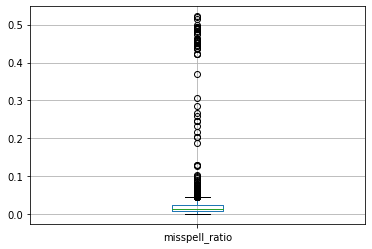

In [39]:
boxplot = mnorm_df.boxplot(column=["misspell_ratio"])

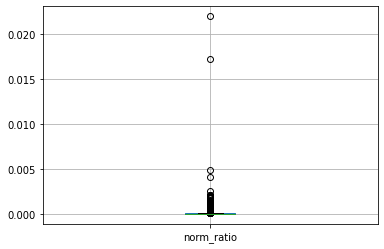

In [61]:
boxplot = mnorm_df.boxplot(column=["norm_ratio"])

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

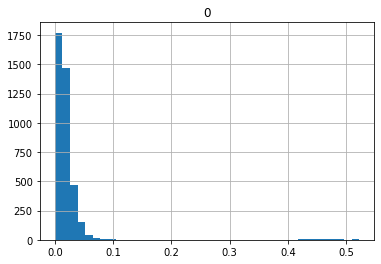

In [40]:
mp_df.hist(bins=40)   # most misspellings lies between 0 and 1

#### **2. Ratio of random capitalizations**

In [63]:
def read_file(filename):
    with open(filename, 'r') as file:
        data = file.read().replace('\n', '')
    return data

str1=read_file(os.path.join(path_to_data, "opinion_1.txt"))
str2=read_file(os.path.join(path_to_data, "academic_journal_2.txt"))
str3=read_file(os.path.join(path_to_data, "opinion_2.txt"))
str4=read_file(os.path.join(path_to_data, "opinion_4.txt"))
str5=read_file(os.path.join(path_to_data, "opinion_3.txt"))
str6=read_file(os.path.join(path_to_data, "academic_journal_3.txt"))
str7=read_file(os.path.join(path_to_data, "diary_4.txt"))
str8=read_file(os.path.join(path_to_data, "poem_1.txt"))
str9=read_file(os.path.join(path_to_data, "poem_2.txt"))
str10=read_file(os.path.join(path_to_data, "poem_3.txt"))
str11=read_file(os.path.join(path_to_data, "poem_4.txt"))

# Create a list of strings from all txt files
strlist=[str1,str2,str3,str4,str5,str6,str7,str8,str9,str10,str11]

FileNotFoundError: [Errno 2] No such file or directory: 'opinion_1.txt'

In [64]:
# Counts number of capital letters and periods in a string and returns the ratio
def count_period_ratio(string):
    """Input is a string of article"""
    period_cnt=0
    capital_cnt=0
    
    for letter in string:
        if letter==".":
            period_cnt+=1
        elif letter.isupper()==True:
            capital_cnt+=1
    
    ratio=capital_cnt/period_cnt
    return ratio

In [65]:
# Make a list of ratios from some test strs (articles, academic journals, poems, and diaries)
ratearray=[]
testarray=[]

for strs in strlist:
    ratearray.append(count_period_ratio(strs))
    
# Take a sample scam email texts to compare thresholds
for i in range (1000):
    try:
        testarray.append(count_period_ratio(messages[i]["X-TIKA:content"].strip().lstrip()))
    except ZeroDivisionError:
        pass
    continue

NameError: name 'strlist' is not defined

In [ ]:
# Output capitalization ratio summary stats from test strs array
df1=pd.DataFrame(ratearray).describe()
df1.columns=["normal_text"]
df1

In [ ]:
# Output capitalization ratio summary stats from sample scam emails array
df2=pd.DataFrame(testarray).describe()
df2.columns=["999_scam_text"]
df2

<font color=darkblue>**Visualization of capitalization ratio distribution**</font>

In [ ]:
fig, ax = plt.subplots(figsize=(8,4,))
counts, bins, patches = ax.hist(cap_df, facecolor="orange", edgecolor='gray',bins=100)
#ax.set_xticks(bins.round(2))
#plt.xticks(rotation=70)
plt.title('Distribution of capitalization ratio', fontsize=15)
plt.ylabel('Frequency', fontsize=10)
plt.xlabel('Capitalization Ratio', fontsize=10)

for patch, leftside, rightside in zip(patches, bins[:-1], bins[1:]):
    if rightside < 1:
        patch.set_facecolor("peachpuff")
    elif leftside > 3.76:
        patch.set_facecolor("deepskyblue")

<font color=darkblue>**Normalized data based on email message size**</font>

In [ ]:
msg_len=[]
for message in messages:
    msg_len.append(len(message["X-TIKA:content"].strip().lstrip().split(" ")))

norm_df=pd.concat([cap_df,pd.DataFrame(msg_len)],axis=1)
norm_df.columns=["cap_ratio","msg_size"]
norm_df["norm_ratio"]=norm_df["cap_ratio"]/norm_df["msg_size"]

boxplot1 = norm_df.boxplot(column=["cap_ratio"])
boxplot2 = norm_df.boxplot(column=["norm_ratio"])

<font color=darkblue>**Normalized Data Visualization**</font>

In [ ]:
norm_df.describe()

In [ ]:
boxplot1 = norm_df.boxplot(column=["cap_ratio"])
boxplot2 = norm_df.boxplot(column=["norm_ratio"])

# basic plot
axs[0, 0].boxplot1(data)
axs[0, 0].set_title('Cap_Ratios')

# try axs[0, 1].boxplot2(data).set_title('Normalized_Ratios')
axs[0, 1].boxplot2(data)
axs[0, 1].set_title('Normalized_Ratios')

# Multiple box plots on one Axes
data = [boxplot1, boxplot1]
fig, axs = plt.subplots(1, 2)
ax.boxplot(data)

plt.show()

### *ix. Attacker estimated age*

- https://github.com/USCDataScience/AgePredictor

*New key: ```AgePredictor```*

1. Clone containerized AgePredictor repo into current working directory (https://github.com/frytoli/usc-agepredictor-docker)
2. Download The Blog Authorship Corpus from https://u.cs.biu.ac.il/~koppel/BlogCorpus.htm to ```usc-agepredictor-docker/data/```, extract the zip, and prepare the data to be used as training data for the AgePredictor (data in ```usc-agepredictor-docker/data/blogs.txt```):

In [41]:
!{sys.executable} -m pip install lxml

from lxml import etree
#import os
#import re

In [ ]:
# Prepare training data for age predictor

# Classic whitespace pattern
whitespace_ptrn = re.compile(r'\s')

# Define path to usc-agepredictor-docker/data
path_to_agepredictor_data = os.path.join(os.getcwd(), 'usc-agepredictor-docker', 'data')

# Define path to blogs training data file
path_to_trainfile = os.path.join(path_to_agepredictor_data, 'blogs.txt')
# If file already exists, delete it
if os.path.exists(path_to_trainfile):
    os.remove(path_to_trainfile)

# Get list of files included in the blogs dataset
blogs_files = os.listdir(os.path.join(path_to_agepredictor_data, 'blogs'))

# Iterate over the blog files
for bf in blogs_files:
    # Split the file name by '.' and extract the age value
    age = bf.split('.')[2]
    # Parse xml blog file
    xml_data = open(os.path.join(path_to_agepredictor_data, 'blogs', bf), 'r', encoding="utf-8", errors='ignore').read()
    parser = etree.XMLParser(recover=True)
    tree = etree.fromstring(xml_data, parser=parser)
    
    # Find all of the "post" items
    for post in tree.iter('post'):
        # Strip and normalize text
        text = whitespace_ptrn.sub(' ', post.text.strip())
        # Format string expected by AgePredictor training
        line = f'{age}\t{text}\n'
        # Write line to training file
        if not os.path.exists(path_to_trainfile):
            with open(path_to_trainfile, 'w', encoding='utf-8') as outfile:
                outfile.write(line)
        else:
            with open(path_to_trainfile, 'a', encoding='utf-8') as outfile:
                outfile.write(f'{line}')

print(f'Training data saved to {path_to_trainfile}')

3. Prepare test file for age predictor (data in ```./usc-agepredictor-docker/data/fraud_test.txt```)

In [47]:
# Prepare test file for age predictor

whitespace_ptrn = re.compile(r'\s')
dup_whitespace_ptrn = re.compile(r' {2,}')

# Defined path to fraudulent test data file
path_to_testfile = os.path.join(path_to_agepredictor_data, 'fraud_test.txt')

for message in messages:
    # Normalize message content
    content = whitespace_ptrn.sub(' ', message['X-TIKA:content'])
    content = dup_whitespace_ptrn.sub(' ', content).strip()
    # Append to file
    if not os.path.exists(path_to_testfile):
        with open(path_to_testfile, 'w') as outfile:
            outfile.write(f'{content}\n\n')
    else:
        with open(path_to_testfile, 'a') as outfile:
            outfile.write(f'{content}\n\n')

print(f'Testing data saved to {path_to_testfile}')

Testing data saved to /Users/olivia/Documents/viterbi/DSCI550/assignment1/other/dsci550-assignment1/final_submission/usc-agepredictor-docker/data/fraud_test.txt


4. Build and drop into AgePredictor container:
```
cd usc-agepredictor-docker
docker build . --tag agepredict
docker run -it agepredict /bin/bash
```

Once in the container...

5. Ensure that the training data is formatted correctly (*the grep patterns in this file do not seem to match on my data, but the lines match fine with pure regex*):
```
./data-processing-scripts/scripts/format.sh data/blogs.txt data/blogs1.txt
```

6. Shuffle the training data lines in a random order:
```
./data-processing-scripts/scripts/shuffle.sh data/blogs.txt data/blogs2.txt
```

7. Split dataset into 90% train and 10% test:
```
./data-processing-scripts/scripts/train_test_split.sh data/blogs2.txt data/blogs_train.txt data/blogs_test.txt
```

8. Train and build a ```model/en-ageClassify.bin``` file with the training data:
```
bin/authorage AgeClassifyTrainer -model model/en-ageClassify.bin -lang en -data data/blogs_train.txt -encoding UTF-8
```

9. Test the model with the test data:
```
bin/authorage AgePredict model/en-ageClassify.bin model/regression-global.bin data/blogs_test.txt
```

10. Run the Age prediction on our fraud dataset and grep out the predictions from the output:
```
bin/authorage AgePredict model/en-ageClassify.bin model/regression-global.bin data/fraud_test.txt < data/fraud_test.txt 2>&1 | grep "Prediction" > data/predictions.txt
```

11. Copy the output file from the container (where ```CONT_ID``` is the ID of the stopped container):
```
docker cp $CONT_ID:/AgePredict/data/predictions.txt ./usc-agepredictor-docker/data/predictions.txt

### *x. Attacker IP known as Phisher?*
- https://scamalytics.com/ip

*New key: ```scamlytics```*

<font color=darkblue>**Define functions to lookup IP address and find risk score**</font>

In [48]:
!{sys.executable} -m pip install bs4 requests

import random
from bs4 import BeautifulSoup
#import requests

In [51]:
def select_user():
    user_agents = [
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 11_0_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.198 Safari/537.36',
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 11_0_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.66 Safari/537.36',
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.66 Safari/537.36',
        'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.66 Safari/537.36',
        'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.66 Safari/537.36',
        'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:83.0) Gecko/20100101 Firefox/83.0',	
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 11.0; rv:83.0) Gecko/20100101 Firefox/83.0',
        'Mozilla/5.0 (iPhone; CPU iPhone OS 11_0_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) FxiOS/29.0 Mobile/15E148 Safari/605.1.15',
        'Mozilla/5.0 (iPad; CPU OS 11_0_1 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) FxiOS/29.0 Mobile/15E148 Safari/605.1.15',
        'Mozilla/5.0 (Macintosh; Intel Mac OS X 11_0_1) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0 Safari/605.1.15',
        'Mozilla/5.0 (iPhone; CPU iPhone OS 14_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0 Mobile/15E148 Safari/604.1'
    ]
    return random.choice(user_agents)

def lookup_ip(IP):
    url = 'https://scamalytics.com/ip/'
    d = {}
    try:
        page = requests.get(
            url + IP,
            headers = {'User-Agent': select_user()}
        )
    except:
        print("Error")
    soup = BeautifulSoup(page.content, 'html.parser')
    for text in soup.find_all('pre'):
        if 'ip' in text.string:
            new_data = json.loads(text.string)
            if new_data['ip'] == IP:
                d['risk_score'] = new_data['score']
                d['risk'] = new_data['risk']
    return d


In [52]:
for item in messages:
    if 'IPInfo-data' in item:
        temp = item['IPInfo-data']
        append_info = lookup_ip(temp['ip'])
        if append_info != {}:
            item['scamalytics'] = append_info
            #print(temp['ip'], append_info)
            
save_to_outfile(messages)

Data saved to /Users/olivia/Documents/viterbi/DSCI550/assignment1/other/dsci550-assignment1/final_submission/data/fraudulent_emails.json


## 6.  Analyze and Add Additional Datasets
--- 

In [ ]:
# use messages

### Dataset 1:  Global Unemployment Data

https://data.worldbank.org/indicator/SL.UEM.TOTL.ZS

#### <font color = darkblue>MIME Top-Level: appplication<br>MIME Sub-level: Excel (.xls)</font>   
#### <font color = darkblue>Unemployment New Features</font>
Geographic_NAME:
1. Unemployment by Location (geographic_name_unemployment)
2. Unemployment by Year when email was sent (geographic_year_unemployment)
3. Unemployment by Country (geographic_country_unemployment)

In [79]:
!{sys.executable} -m pip install pandas numpy bs4 requests xlrd
import pandas as pd
import numpy as np
#import json
#import requests
import random
#from bs4 import BeautifulSoup
#import re
#import os

In [80]:
# read in from data directory 
filename = os.path.join(path_to_data, 'API_SL.UEM.TOTL.ZS_DS2_en_excel_v2_2056005.xls')
sheet = 'Data'    # constant 

df = pd.read_excel(filename, sheet_name= sheet)

header_row = 2
df.columns = df.iloc[header_row]
df = df.drop([0,1,header_row])

df = df.set_index('Country Name', drop=False)
df.head()

2,Country Name,Country Code,Indicator Name,Indicator Code,1960.0,1961.0,1962.0,1963.0,1964.0,1965.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
Country Name,,,,,,,,,,,,,,,,,,,,,
Aruba,Aruba,ABW,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Afghanistan,Afghanistan,AFG,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,11.51,11.52,11.54,11.450000,11.390000,11.31,11.18,11.06,10.98,11.73
Angola,Angola,AGO,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,7.36,7.37,7.38,7.310000,7.260000,7.20,7.10,7.00,6.93,7.70
Albania,Albania,ALB,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,13.48,13.38,15.87,18.059999,17.190001,15.42,13.62,12.30,11.47,11.70
Andorra,Andorra,AND,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [94]:
def lookup_location(location, year, df=df):
    d = {}
    for i in df['Country Name']:
        if i.lower() in location.lower():
            d['geographic_name'] = location
            d['year'] = year
            d['country'] = i
            d[str(year) + '_unemployment'] = df.loc[i, year]
            d[str(year-5) + '_unemployment'] = df.loc[i, year-5]
            d[str(year+5) + '_unemployment'] = df.loc[i, year+5]
    return d

In [95]:
for message in messages:
    if 'TIKA-GeoLocationParser' in item:
        year = int(item['timestamp'].split('-')[0])
        GeoLocations = item['TIKA-GeoLocationParser']
        keys = GeoLocations.keys()
        for key in keys:
            regex = re.compile('Optional_NAME[\d]*')
            if key == 'Geographic_NAME':
                location = GeoLocations['Geographic_NAME']
                try:
                    to_append = lookup_location(location, year, df)
                    if to_append != {}:
                        item['TIKA-GeoLocationParser'].append({(key + "_unemployment"): to_append})
                except:
                    print("Error: " + key + " " + location)
            elif re.match(regex, key):
                location = GeoLocations[key]
                try:
                    to_append = lookup_location(location, year, df)
                    if to_append != {}:
                        item['TIKA-GeoLocationParser'].append({(key + "_unemployment"): to_append})
                except:
                    print("Error: " + key + " " + location)

# Save a checkpoint
save_to_outfile(messages)  

Data saved to /Users/olivia/Documents/viterbi/DSCI550/assignment1/dsci550-assignment1/data/fraudulent_emails_final.json


### Dataset 2:  World Bank International Debt Statistics

https://datacatalog.worldbank.org/dataset/international-debt-statistics

#### <font color = darkblue>MIME Top-Level: text<br>MIME Sub-level: csv</font>   
#### <font color = darkblue>Debt New Features</font>
1. Gross National Income (GNI) in USD
2. Total debt service (% of exports of goods, services and primary income)
3. Personal transfers and compensation of employees received in USD

In [84]:
filename = os.path.join(path_to_data, 'IDS-DRSCountries_WLD_Data.csv')
ids_df = pd.read_csv(filename)

ids_df = ids_df.set_index('Country Name', drop=False)
ids_df.head()

,Country Name,Country Code,Counterpart-Area Name,Counterpart-Area Code,Series Name,Series Code,1970,1971,1972,1973,...,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027
Country Name,,,,,,,,,,,,,,,,,,,,,
Afghanistan,Afghanistan,AFG,World,WLD,Average grace period on new external debt comm...,DT.GPA.DPPG,NaN,NaN,NaN,NaN,...,NaN,17.9041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Afghanistan,Afghanistan,AFG,World,WLD,Average grace period on new external debt comm...,DT.GPA.OFFT,NaN,NaN,NaN,NaN,...,NaN,17.9041,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Afghanistan,Afghanistan,AFG,World,WLD,Average grace period on new external debt comm...,DT.GPA.PRVT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Afghanistan,Afghanistan,AFG,World,WLD,Average grant element on new external debt com...,DT.GRE.DPPG,NaN,NaN,NaN,NaN,...,NaN,73.0790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Afghanistan,Afghanistan,AFG,World,WLD,Average grant element on new external debt com...,DT.GRE.OFFT,NaN,NaN,NaN,NaN,...,NaN,73.0790,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
codes = {'GNI_USD':'NY.GNP.MKTP.CD', 
         'Debt_Service_%':'DT.TDS.DECT.EX.ZS', 
         'Employee_Compensation_USD':'BX.TRF.PWKR.CD.DT'}

In [96]:
def lookup_loc(location, year, df=ids_df):
    countries = set(ids_df['Country Name'])
    countries.remove(np.nan)
    countries.remove('Last Updated: 10/16/2020')
    countries.remove('Least developed countries: UN classification')
    countries.remove('Data from database: International Debt Statistics')

    d = {}
    
    if location == 'Federal Republic of Nigeria':
        d['country'] = 'Nigeria'
        d['geographic_name'] = location
        d['year'] = year
        df1 = df.loc['Nigeria', ['Series Code', year]]
        for key, value in codes.items():
            d[year + '_' + key] = df1.loc[df1['Series Code'] == value, year].values[0]
    else:
        for i in countries:
            if i.lower() in location.lower():
                d['geographic_name'] = location
                d['year'] = year
                d['country'] = i
                df1 = df.loc[i, ['Series Code', year]]
                for key, value in codes.items():
                    d[year + '_' + key] = df1.loc[df1['Series Code'] == value, year].values[0]
    return d

In [97]:
for item in messages:
    if 'TIKA-GeoLocationParser' in item:
        year = item['timestamp'].split('-')[0]
        GeoLocations = item['TIKA-GeoLocationParser']
        keys = GeoLocations.keys()
        for key in keys:
            regex = re.compile('Optional_NAME[\d]*')
            if key == 'Geographic_NAME':
                location = GeoLocations['Geographic_NAME']
                try:
                    to_append = lookup_loc(location, year, ids_df)
                    if to_append != {}:
                        item['TIKA-GeoLocationParser'].append({(key + "_economic_data"): to_append})
                except:
                    print("Error: " + key + " " + location)
            elif re.match(regex, key):
                location = GeoLocations[key]
                try:
                    to_append = lookup_loc(location, year, ids_df)
                    if to_append != {}:
                        item['TIKA-GeoLocationParser'].append({(key + "_economic_data"): to_append})
                except:
                    print("Error: " + key + " " + location)
            else:
                continue

### Dataset 3:  Enron Email Corpus
#### <font color = darkblue>MIME Top-Level: message<br>MIME Sub-level: message</font>   
#### <font color = darkblue>Enron New Features</font>
1. 
2. 
3. 

In [ ]:
# coming soon!

### Dataset 4: Google Earth Engine

https://developers.google.com/earth-engine/datasets/

Images of the best geolocation match as identified by Tika's GeoLocationParser (```Geographic_LONGITUDE```, ```Geographic_LATITUDE```) collected from the four following collections. This uses the accompanying class ```geengine``` in ```./gee/gee.py```. All images are downloaded as PNGs with a max dimension (height or width) of 500px and stored within our dataset as base64 encoded strings. All base64 encoded strings can be decoded back to bytes and written to an image (PNG) file. **This is really slow.**

[CIESIN/GPWv411/GPW_Population_Density](https://developers.google.com/earth-engine/datasets/catalog/CIESIN_GPWv411_GPW_Population_Density) collected from 2000-01-01T00:00:00 - 2020-01-01T00:00:00: The Gridded Population of World Version 4 (GPWv4), Revision 11 models the distribution of global human population for the years 2000, 2005, 2010, 2015, and 2020 on 30 arc-second (approximately 1km) grid cells. Population is distributed to cells using proportional allocation of population from census and administrative units. Population input data are collected at the most detailed spatial resolution available from the results of the 2010 round of censuses, which occurred between 2005 and 2014. The input data are extrapolated to produce population estimates for each modeled year. These population density grids contain estimates of the number of persons per square kilometer consistent with national censuses and population registers. There is one image for each modeled year.

[CIESIN/GPWv411/GPW_Population_Count](https://developers.google.com/earth-engine/datasets/catalog/CIESIN_GPWv411_GPW_Population_Count) collected from 2000-01-01T00:00:00 - 2020-01-01T00:00:00: The Gridded Population of World Version 4 (GPWv4), Revision 11 models the distribution of global human population for the years 2000, 2005, 2010, 2015, and 2020 on 30 arc-second (approximately 1km) grid cells. Population is distributed to cells using proportional allocation of population from census and administrative units. Population input data are collected at the most detailed spatial resolution available from the results of the 2010 round of censuses, which occurred between 2005 and 2014. The input data are extrapolated to produce population estimates for each modeled year. These population count grids contain estimates of the number of persons per 30 arc-second grid cell consistent with national censuses and population registers. There is one image for each modeled year.

[LANDSAT/LE07/C01/T1](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LE07_C01_T1) collected from 1999-01-01T00:00:00 - 2021-02-13T00:00:00: Landsat 7 Collection 1 Tier 1 DN values, representing scaled, calibrated at-sensor radiance. Landsat scenes with the highest available data quality are placed into Tier 1 and are considered suitable for time-series processing analysis. Tier 1 includes Level-1 Precision Terrain (L1TP) processed data that have well-characterized radiometry and are inter-calibrated across the different Landsat sensors. The georegistration of Tier 1 scenes will be consistent and within prescribed tolerances [<=12 m root mean square error (RMSE)]. All Tier 1 Landsat data can be considered consistent and inter-calibrated (regardless of sensor) across the full collection. See more information in the USGS docs.

[CIESIN/GPWv411/GPW_National_Identifier_Grid](https://developers.google.com/earth-engine/datasets/catalog/CIESIN_GPWv411_GPW_National_Identifier_Grid) collected from 2000-01-01T00:00:00 - 2020-01-01T00:00:00: The Gridded Population of World Version 4 (GPWv4), Revision 11 models the distribution of global human population for the years 2000, 2005, 2010, 2015, and 2020 on 30 arc-second (approximately 1km) grid cells. Population is distributed to cells using proportional allocation of population from census and administrative units. Population input data are collected at the most detailed spatial resolution available from the results of the 2010 round of censuses, which occurred between 2005 and 2014. The input data are extrapolated to produce population estimates for each modeled year. The National Identifier Grid Represents the Census Data Source Used to Produce the GPWv4 Populations estimates. Pixels that have the same value reflect the same data source, most often a country or territory.

**** NOTE:** There's a known issue with the current version of google-api-python-client that has yet to be fixed ( (See https://github.com/google/earthengine-api/issues/160). A suggested workaround is to downgrade google-api-python-client to version 1.12.8. This does not seem to do the trick for me in this notebook, but it does work when running the following code as a script in a virtualenv. As such, in the case that the code in the following cell throws a related error, I have included instructions to run the code from a script.

In [ ]:
# THIS MIGHT NOT WORK DUE TO EARTH ENGINE API ISSUE 160

#from datetime import datetime, timedelta, timezone
from IPython.display import Image
from gee.gee import geengine
import dateutil.parser
import time
import json

# Initialize custom Google Earth Engine object
engine = geengine()

# Iterate over messages and look for good geolocation matches
for message in messages:
    if 'TIKA-GeoLocationParser' in message:
        # Save parsed geolocation data
        geolocation = message['TIKA-GeoLocationParser']
        # Opting not to filter on timestamp because testing has shown that few images are available within filtered date ranges
        #timestamp = dateutil.parser.parse(message['timestamp']).replace(tzinfo=timezone.utc).astimezone(tz=None)
        if 'Geographic_LONGITUDE' in geolocation:
            # Create new key-value pair in message record
            message['GoogleEarthEngine'] = {
                'name': geolocation['Geographic_NAME'],
                'longitude': geolocation['Geographic_LONGITUDE'],
                'latitude': geolocation['Geographic_LATITUDE']
            }
            # Get population density image bytes
            image = engine.get_population_density_img(float(geolocation['Geographic_LONGITUDE']), float(geolocation['Geographic_LATITUDE']))
            # Convert bytes to base64 encoded string and save
            message['GoogleEarthEngine'][engine.collections['population_density']['name']] = engine.image_to_b64(image)
            # Get population count image bytes
            image = engine.get_population_count_img(float(geolocation['Geographic_LONGITUDE']), float(geolocation['Geographic_LATITUDE']))
            # Convert bytes to base64 encoded string and save
            message['GoogleEarthEngine'][engine.collections['population_count']['name']] = engine.image_to_b64(image)
            # Get raw land image bytes (this can take a while, so skip it if it timesout)
            try:
                image = engine.get_raw_land_img(float(geolocation['Geographic_LONGITUDE']), float(geolocation['Geographic_LATITUDE']))
            except HTTPError:
                print('HTTPError: Request for raw land image (LANDSAT/LE07/C01/T1) timedout')
                image = b''
            # Convert bytes to base64 encoded string and save
            message['GoogleEarthEngine'][engine.collections['raw_land']['name']] = engine.image_to_b64(image)
            # Get country boundaries image bytes
            image = engine.get_country_boundaries_img(float(geolocation['Geographic_LONGITUDE']), float(geolocation['Geographic_LATITUDE']))
            # Convert bytes to base64 encoded string and save
            message['GoogleEarthEngine'][engine.collections['country_boundaries']['name']] = engine.image_to_b64(image)
            # Save an example
            example = message['GoogleEarthEngine']
            # Sleep so we don't blast Google
            time.sleep(3)

# Save a checkpoint
save_to_outfile(messages)

# Show the example of retrieved images
print(f'''Name: {example['name']}  Long: {example['longitude']}  Lat: {example['latitude']}\n''')
print('Population Density:')
Image.display(data=engine.b64_to_image(example['population_density']))
print('Population Count:')
Image.display(data=engine.b64_to_image(example['population_count']))
print('Raw Land:')
Image.display(data=engine.b64_to_image(example['raw_land']))
print('Country Boundaries:')
Image.display(data=engine.b64_to_image(example['country_boundaries']))

If the above did not work...

1. Change directory to the ```gee/``` directory in this current working directory:
```
cd ./gee
```
2. Build and activate a virtualenv with python3:
```
virtualenv -p python3 venv
. venv/bin/activate
```
3. Install requirements:
```
python -m pip install -r requirements.txt
```
4. Run the script:
```
python main.py
```

## Export Updated JSON File with Additional Datasets

In [98]:
with open(path_to_featurefile , 'w') as outfile:
    json.dump(messages, outfile, indent=2)

## 7.  Tika Similarity
--- 
https://github.com/chrismattmann/tika-similarity with code modifications from Jiarui Ou (thank you!!)

1. Prepare messages for feature similarity evaluation: create separate files for stylometric features of each message

```misspelled_ratio```, ```Sentiment-Analysis```, ```se_tags```, ```attacker_offering```, ```attacker_titles```, ```urgency_score```, ```TIKA-language```

In [ ]:
#import os

In [ ]:
# Iterate over messages
count = 0
for message in messages:
    # Create a temporary dict for the features of the message we're interested in
    temp = {
        'misspelled_ratio': message['misspelled_ratio'],
        'se_tags': message['se_tags'],
        'urgency_score': message['urgency_score'],
        'TIKA-language': message['TIKA-language']
    }
    if 'Sentiment-Analysis' in message:
        temp['Sentiment-Analysis'] = message['Sentiment-Analysis']
    else:
        temp['Sentiment-Analysis'] = None
    if 'attacker_offering' in message:
        temp['attacker_offering'] = message['attacker_offering']
    else:
        temp['attacker_offering'] = None
    if 'attacker_titles' in message:
        temp['attacker_titles'] = message['attacker_titles']
    else:
        temp['attacker_titles'] = None
        
    # Write temp to a file in Tika Simiarity's input directory
    with open(os.path.join(path_to_tikasimilarity, 'input', f'{count}.json'), 'w') as outjson:
        json.dump(temp, outjson, indent=2)
    count += 1

2. Build and drop into tika-similarity docker container
```
cd tika-similarity
docker build . --tag tikasim
docker run -it --volume output:/output tikasim /bin/bash
```

3. Once in container, run key-based comparison (output in ```similarity-scores.txt```):
```
python similarity.py -f input
```

4. Run value-based comparison (output in ```value-similarity-scores.txt```):
```
python value-similarity.py -f input
```

5. Perform Edit Distance Comparison and save output CSV in ```./tika-similarity/output```:
```
python edit-value-similarity.py --jsonDir input --outCSV '/output/edit.csv'
```

6. Perform Cosine Distance Comparison and save output CSV in ```./tika-similarity/output```:
```
python cosine_similarity.py --jsonDir input --outCSV '/output/cosine.csv'
```

7. Perform Jaccard Similarity and save output CSV in ```./tika-similarity/output```:
```
python jaccard_similarity.py --jsonDir input --outCSV '/output/jaccard.csv'
```

8. Start local webserver to view visualizations:
```
python -m http.server
```

#### Jaccard Similarity

9. Read-in and look through resulting CSV:

In [71]:
import pandas as pd
#import os

In [79]:
jaccard_df = pd.read_csv(os.path.join(path_to_tikasimilarity, 'output', 'jaccard.csv'))
jaccard_df

,x-coordinate,y-coordinate,Similarity_score
0,input/3583.json,input/3425.json,0.400000
1,input/3583.json,input/3180.json,0.400000
2,input/3583.json,input/3228.json,0.400000
3,input/3583.json,input/2055.json,0.400000
4,input/3583.json,input/381.json,0.400000
...,...,...,...
7910248,input/2639.json,input/3236.json,0.400000
7910249,input/2639.json,input/3643.json,0.400000
7910250,input/1933.json,input/3236.json,0.400000
7910251,input/1933.json,input/3643.json,0.555556


In [80]:
# Calculate mean/median/mode of Similarity_score values
print(f'''Mean:   {jaccard_df['Similarity_score'].mean()}''')
print(f'''Median: {jaccard_df['Similarity_score'].median()}''')
print(f'''Mode:   {jaccard_df['Similarity_score'].mode()}''')

Mean:   0.455049787850647
Median: 0.4
Mode:   0    0.4
dtype: float64


10. Generate visualizations (in container):
```
python cluster-scores.py
python circle-packing.py
```

11. Copy appropriate files from container to host:
```
docker cp $CONTAINER_ID:/tika-img-similarity/clusters.json ./tika-img-similarity
docker cp $CONTAINER_ID:/tika-img-similarity/circle.json ./tika-img-similarity
```

10. Open visualizations with local webserver in browser (i.e. visit 127.0.0.1:8000/tika-img-similarity/circlepacking.html in the browser)

#### Edit Similarity

13. Read-in and look through resulting CSV:

In [81]:
edit_df = pd.read_csv(os.path.join(path_to_tikasimilarity, 'output', 'edit.csv'))
edit_df

,x-coordinate,y-coordinate,Similarity_score
0,input/3583.json,input/3425.json,0.684848
1,input/3583.json,input/3180.json,0.718881
2,input/3583.json,input/3228.json,0.701587
3,input/3583.json,input/2055.json,0.706349
4,input/3583.json,input/381.json,0.663420
...,...,...,...
7910248,input/2639.json,input/3236.json,0.672487
7910249,input/2639.json,input/3643.json,0.679630
7910250,input/1933.json,input/3236.json,0.714815
7910251,input/1933.json,input/3643.json,0.764286


In [82]:
# Calculate mean/median/mode of Similarity_score values
print(f'''Mean:   {edit_df['Similarity_score'].mean()}''')
print(f'''Median: {edit_df['Similarity_score'].median()}''')
print(f'''Mode:   {edit_df['Similarity_score'].mode()}''')

Mean:   0.7316302011778495
Median: 0.7260015117157974
Mode:   0    0.757143
dtype: float64


14. Generate visualizations (in container):
```
python cluster-scores.py
python circle-packing.py
```

15. Copy appropriate files from container to host:
```
docker cp $CONTAINER_ID:/tika-img-similarity/clusters.json ./tika-img-similarity
docker cp $CONTAINER_ID:/tika-img-similarity/circle.json ./tika-img-similarity
```

16. Open visualizations with local webserver in browser (i.e. visit 127.0.0.1:8000/tika-img-similarity/circlepacking.html in the browser)

#### Cosine Distance

17. Read-in and look through resulting CSV:

In [83]:
cosine_df = pd.read_csv(os.path.join(path_to_tikasimilarity, 'output', 'cosine.csv'))
cosine_df

,x-coordinate,y-coordinate,Similarity_score
0,input/3583.json,input/3425.json,0.998751
1,input/3583.json,input/3180.json,0.981591
2,input/3583.json,input/3228.json,0.984337
3,input/3583.json,input/2055.json,0.986794
4,input/3583.json,input/381.json,0.998751
...,...,...,...
7910248,input/2639.json,input/3236.json,0.923609
7910249,input/2639.json,input/3643.json,0.923609
7910250,input/1933.json,input/3236.json,1.000000
7910251,input/1933.json,input/3643.json,1.000000


In [84]:
# Calculate mean/median/mode of Similarity_score values
print(f'''Mean:   {cosine_df['Similarity_score'].mean()}''')
print(f'''Median: {cosine_df['Similarity_score'].median()}''')
print(f'''Mode:   {cosine_df['Similarity_score'].mode()}''')

Mean:   0.965648404146931
Median: 0.9937228665593968
Mode:   0    1.0
dtype: float64


### Tika Similarity Clusters and Comparison

## 8.  Save as TSV
--- 

In [59]:
import csv

In [60]:
# Method for recursively "flattening" a dictionary value
def flatten(nested, flat):
    for key, value in nested.items():
        if not type(value) == dict:
            flat[key] = value
        else:
            # Add key to value's keys
            new_keys = [f'{key}-{valkey}' for valkey in value.keys()]
            value = dict(zip(new_keys, list(value.values())))
            flatten(value, flat)
    return flat

In [63]:
# Save "flattened" message blobs to new variable
flat_messages = []
# Record all keys (these will be TSV headers)
keys = set()
# Iterate and "flatten" all messages
for message in messages:
    # Flatten and save
    temp_flat = flatten(message, {})
    flat_messages.append(temp_flat)
    # Save keys
    keys = keys.union(set(temp_flat.keys()))

# Order keys in alphabetical order
keys = sorted(keys)

# Now, write TSV
with open(path_to_tsvfile, 'w') as outtsv:
    writer = csv.writer(outtsv, delimiter='\t')
    # Write header row
    writer.writerow([key for key in keys])
    # Iterate over flattened messages and write a row for each
    for message in flat_messages:
        row = []
        for key in keys:
            try:
                row.append(message[key])
            except KeyError:
                # If the key does not exist in the message, write an empty string
                row.append('')
        writer.writerow(row)

print(f'Final data saved to {path_to_tsvfile}')

Final data saved to /Users/olivia/Documents/viterbi/DSCI550/assignment1/other/dsci550-assignment1/final_submission/data/fraudulent_emails.tsv
